In [1]:
%matplotlib inline

import time
from multiprocessing import Pool
from multiprocessing import cpu_count
from PRD_h_f2 import hf
import numpy as np
import matplotlib.pyplot as plt


from pycbc.types.timeseries import TimeSeries
from pycbc.types.frequencyseries import FrequencySeries
import pycbc.psd
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.waveform import td_approximants, fd_approximants


In [2]:
sampFreq = 2**14              #采样频率(Sampling frequency)，单位时间样本点个数，应大于 2f（即Nyquist频率)
duration = 2**2               #信号持续时间(duration of signal) 2^16, 0.75d, 2^25 ,1.06yr


n = int(duration * sampFreq)#采样点数(Sampling Number), 有时也称为信号长度(Length of Signal) 2^16
                            #为2的幂时，快速傅里叶变化效率最高
                            #n =  duration * sampFreqint = (duration / sampIntrvl)

sampIntrvl = 1.0 / sampFreq                   #采样周期(Sampling period)，隔多少时间取样一次，或步长
freqIntrvl = sampFreq / n                     #傅里叶变换 频率分辨率(Frequency Interval) 
                                              # freqIntrvl = 1 / duration = 1 / (n * sampIntrvl)
                                              #            = sampFreq / n  
        

f_max = sampFreq/2             #信号模式的最大频率

print("采样频率为%fHz，信号持续时间%fs, 时域信号采样%d 个点"%(sampFreq,duration,n))
print("信号中可分析最大频率为%fHz"%f_max)
print("\n采样周期，即时域分辨率为%fs"%(sampIntrvl))
print("信号频域的频率间隔，即频域分辨率为%fHz"%freqIntrvl);

采样频率为16384.000000Hz，信号持续时间4.000000s, 时域信号采样65536 个点
信号中可分析最大频率为8192.000000Hz

采样周期，即时域分辨率为0.000061s
信号频域的频率间隔，即频域分辨率为0.250000Hz


In [3]:
#列出频率波形
low_frequency_cutoff = 20                     #截止频率

print(fd_approximants())

hpf, hcf = get_fd_waveform(approximant="IMRPhenomPv2",
                             mass1=10, mass2=10, delta_f=freqIntrvl,distance = 100, f_lower=low_frequency_cutoff)

#distance = 100 Mpc

#print((hpf.sample_frequencies))

hp = hpf.to_timeseries()
hc = hcf.to_timeseries()

help(get_fd_waveform)

['EccentricFD', 'TaylorF2', 'TaylorF2Ecc', 'TaylorF2NLTides', 'TaylorF2RedSpin', 'TaylorF2RedSpinTidal', 'SpinTaylorF2', 'EOBNRv2_ROM', 'EOBNRv2HM_ROM', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBNRv2_ROM_DoubleSpin', 'SEOBNRv2_ROM_DoubleSpin_HI', 'Lackey_Tidal_2013_SEOBNRv2_ROM', 'SEOBNRv4_ROM', 'SEOBNRv4_ROM_NRTidal', 'SEOBNRv4T_surrogate', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidal', 'IMRPhenomHM', 'IMRPhenomP', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'SpinTaylorT4Fourier', 'SpinTaylorT2Fourier', 'NRSur4d2s', 'SpinTaylorF2_SWAPPER', 'TaylorF2NL', 'TaylorF2_INTERP', 'SEOBNRv1_ROM_EffectiveSpin_INTERP', 'SEOBNRv1_ROM_DoubleSpin_INTERP', 'SEOBNRv2_ROM_EffectiveSpin_INTERP', 'SEOBNRv2_ROM_DoubleSpin_INTERP', 'EOBNRv2_ROM_INTERP', 'EOBNRv2HM_ROM_INTERP', 'SEOBNRv2_ROM_DoubleSpin_HI_INTERP', 'SEOBNRv4_ROM_INTERP', 'SEOBNRv4', 'IMRPhenomC_INTERP', 'IMRPhenomD_INTERP', 'IMRPhenomPv2_INTERP', 'IMRPhenomD_NRTida

In [4]:
Pi = np.pi 

# $Assumptions  
#{{Fc, Fp, i, \[Beta], e, et0, \[Chi]} belongs to  Reals  
#  0 <= e    <= 1 
#  0 <= et0  <= 1  
#       Chi  >  0 
#  0 <= i    <= Pi/2 
#  0 <= Beta <= Pi/2 
# -1 <= Fc   <= 1 
# -1 <= Fp   <= 1 
#  0 <  Eta  <=0.25 
#(* Assumptions to simplify computations *)   


Fp = 1; 
Fc = 0.0;     # (*  Choosing antenna patterns for \Theta=0^\(Degree), Phi= 30^\(Degree) and \(Psi)=30^\(Degree) *)

Phic = 0;                     #(* Orbital phase at coalescence *)
tc = 0;                       #(* \Time of coalescence *)

m1 = 10; 
m2 = 10;             #(* Mass of the binary \components in solar mass units *)

d = 100*3.086e22;             #(* Distance to the binary in S.I. units *)  #100 Mpc

i = 0.000000001; 
Beta = 0.000000001;        #(* Choose any value for angles relating line of sight to the \orbital plane of the binary*)

et0 = 0.00000000000000000000001;                    #(* Eccentricity at lower cut-off frequency of the \detector, f0 i.e. et0 = et(f0) *)


def hf_f(f):
    return hf(f, Fp = Fp, Fc = Fc, Phic = Phic, tc = tc, \
                 m1 = m1, m2 = m2, d  = d, i  = i, Beta = Beta, et0  = et0)

In [5]:
core = cpu_count()
print("cores = %d"%core)

ntol = 128
#Variables
                  
f = np.linspace(low_frequency_cutoff, 256, ntol + 1);      #(* GW or Fourier \frequency *)
print(f)
f = f.tolist()

cores = 8
[ 20.       21.84375  23.6875   25.53125  27.375    29.21875  31.0625
  32.90625  34.75     36.59375  38.4375   40.28125  42.125    43.96875
  45.8125   47.65625  49.5      51.34375  53.1875   55.03125  56.875
  58.71875  60.5625   62.40625  64.25     66.09375  67.9375   69.78125
  71.625    73.46875  75.3125   77.15625  79.       80.84375  82.6875
  84.53125  86.375    88.21875  90.0625   91.90625  93.75     95.59375
  97.4375   99.28125 101.125   102.96875 104.8125  106.65625 108.5
 110.34375 112.1875  114.03125 115.875   117.71875 119.5625  121.40625
 123.25    125.09375 126.9375  128.78125 130.625   132.46875 134.3125
 136.15625 138.      139.84375 141.6875  143.53125 145.375   147.21875
 149.0625  150.90625 152.75    154.59375 156.4375  158.28125 160.125
 161.96875 163.8125  165.65625 167.5     169.34375 171.1875  173.03125
 174.875   176.71875 178.5625  180.40625 182.25    184.09375 185.9375
 187.78125 189.625   191.46875 193.3125  195.15625 197.      198.84375
 200.687

In [6]:
time0 = time.time()
with Pool() as pool:
    hans_f = pool.map(hf_f, f)
timet = time.time()
print("cost %4.1fs"%(timet-time0))

cost 619.8s


In [7]:
freqIntrvl2 = f[1]-f[0]
htol_f = FrequencySeries(hans_f, delta_f=freqIntrvl2, epoch='', dtype=None, copy=True)
htol = htol_f.to_timeseries()

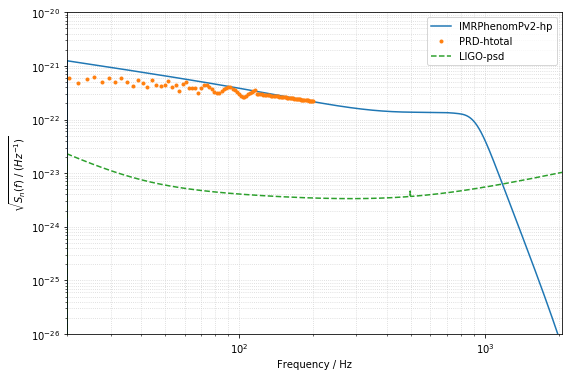

In [18]:
# 列出lalsuite内置的解析psd (没发现有LISA的，下面以LIGO的作为示例)
#print(pycbc.psd.get_lalsim_psd_list())


#示例，psd参见， https://dcc.ligo.org/LIGO-T1800044/public

psd = pycbc.psd.from_string('aLIGOaLIGODesignSensitivityT1800044', n, freqIntrvl, low_frequency_cutoff)

#绘制 频率 - sqrt(PSD) 图
plt.figure(figsize=(8,8/1.5))
plt.loglog(hpf.sample_frequencies, 2 * np.sqrt(hpf.sample_frequencies) * abs(hpf), label = 'IMRPhenomPv2-hp')
plt.loglog(htol_f.sample_frequencies, 2 * np.sqrt(htol_f.sample_frequencies) * abs(htol_f), 'o', markersize= 3,label = 'PRD-htotal')
plt.loglog(psd.sample_frequencies, np.sqrt(psd),"--", label = 'LIGO-psd')
plt.xlim(20,2048)
plt.ylim(1e-26,1e-20)
plt.xlabel("Frequency / Hz")
plt.ylabel("$\sqrt{S_{n}(f) \ / \ (Hz^{-1})}$")
plt.legend()
plt.tight_layout()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
plt.show()

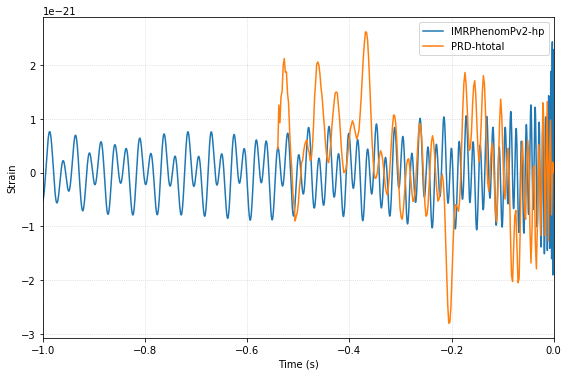

In [9]:
# hp, hc = get_td_waveform(approximant="IMRPhenomPv2",
#                              mass1=6, mass2=6, delta_t =sampIntrvl, f_lower=low_frequency_cutoff)

plt.figure(figsize=(8,8/1.5))
plt.plot(hp.sample_times, hp, label='IMRPhenomPv2-hp')
# plt.plot(hc.sample_times, hc, label='IMRPhenomPv2-hc')
plt.plot(-np.array(htol.sample_times), htol, label='PRD-htotal')
plt.xlim(-1.0,0.0)
plt.ylabel('Strain')
plt.xlabel('Time (s)')
plt.legend()
plt.tight_layout()
plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
plt.show()

In [10]:
htol_flist  = list(htol_f)

for i in range(len(htol_flist )):
    print("%4.2f "%f[i], htol_flist[i], abs( htol_flist[i]))

20.00  (1.3867136045055178e-22+2.4941666199263964e-23j) 1.4089653268268303e-22
21.84  (2.5757344608424368e-23+1.3482219141654308e-22j) 1.372605700834588e-22
23.69  (-1.0070817672608182e-22+2.8245691852612474e-23j) 1.0459424442924412e-22
25.53  (4.7068379879395245e-23+8.184401042802285e-23j) 9.441331700249373e-23
27.38  (1.061560358762994e-22+1.3553139640526445e-25j) 1.0615612239399842e-22
29.22  (-3.308193337531238e-23-8.675183331542506e-23j) 9.284554323948943e-23
31.06  (7.078113231878888e-23+4.5790712986929176e-23j) 8.430159006911568e-23
32.91  (8.163639997393454e-23+1.9681571494894848e-23j) 8.397538959250428e-23
34.75  (-6.728743314162665e-23+3.726992114911428e-23j) 7.691973531708279e-23
36.59  (4.4503074435510135e-23+5.816372615031988e-23j) 7.323621149337232e-23
38.44  (3.191304906036112e-23+5.666237973080287e-23j) 6.503128460277189e-23
40.28  (-6.411660005917327e-23+2.1049630364065668e-23j) 6.748351903696023e-23
42.12  (4.284914042738117e-23-2.779919922038956e-23j) 5.1076847129206